In [1]:
%pip install qualtran

Note: you may need to restart the kernel to use updated packages.


# Optimizing T Counts Given an Error Budget

Quantum algorithms typically only allow us to estimate properties to within some additive error $\epsilon$. Oftentimes this error is made up of multiple sources. For example, trotterized quantum phase estimation introduces at least three sources of error [[1]](https://arxiv.org/abs/1902.10673): Trotter errors ($\Delta_{TS}$) which arise from approximately representing the time evolution operator as a product of time evolution operators, circuit synthesis errors ($\Delta_{HT}$) arising from synthesising single-qubit rotations to a given precision, and phase estimation errors ($\Delta_{PE}$). Given an allowable error for our algorithm (the error budget), we can try to minimize the cost of phase estimation subject to the constraint that $\epsilon \ge \Delta_{TS} + \Delta_{HT} + \Delta_{PE}$.

In this tutorial we will use qualtran to produce an expression for the symbolic T cost of Trotterization which can then be optimized subject to this constraint. We will focus on a simplified version of the analysis given in [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238). To do so we will:

1. Define high level bloqs which implement the unitaries necessary for the trotter decomposition. The goal here is just to capture costs. 
2. Define a bloq which implements the trotterized unitary using Step 1.
3. Define a phase estimation bloq which accepts your unitary.
4. Produce a symbolic cost estimate in terms of these errors and the system parameters ($L$).  
5. (Optional) Numerically optimize the T-counts

## 1. Hubbard Model Trotter Bloqs

The Hubbard model is given as

$$
    H = H_I + H_h
$$
where
$H_I$
$$
H_I = U \sum_i n_{i\uparrow}n_{i\downarrow}
$$
and
$$
H_h = -\tau \sum_\sigma \sum_{\langle i, j\rangle} a_{i\sigma}^\dagger a_{i\sigma} + \mathrm{h.c.}
$$
where $a_{i\sigma}^\dagger a_{i\sigma}$ is a fermionic creation (annihilation) operator, $\tau$ and $U$ are the hopping and Hubbard $U$ parameter respectively, and the sum $\langle i, j\rangle$ is over nearest neighbours.

Following [the reference](https://arxiv.org/abs/1902.10673), we will further write

$$
H_h = H_h^p + H_h^g
$$

as a sum over "pink" and "gold" plaquettes (these are just alternating square patches, the union of which tiles the 2D lattice). The details do not matter much here, but using this Hamiltonian one arrives at the Strang splitting Trotter formula

$$
U = e^{-i t H} \approx e^{-it/2 H_I} e^{-it/2 H_h^p} e^{-it H_h^g} e^{i t/2 H_h^p} e^{-it H_h}.
$$

Your first task is to write the bloqs defining $U_I=e^{-it H_I}$ and $U_h = e^{-it H_h^{p/g}}$. In this tutorial we are only really interested in costs so you don't need to worry about the details of how you might implement the decompositions.


In [2]:
import attrs
import sympy
from functools import cached_property
from typing import Set, Dict, Tuple

from qualtran import Bloq, QAny, QBit, Register, Signature, BloqBuilder, SoquetT
from qualtran.symbolics import SymbolicFloat, SymbolicInt
from qualtran.resource_counting import BloqCountT, SympySymbolAllocator

In [3]:
# TODO: import the relevant gates you need (hint rotations, t_gate)
from qualtran.bloqs.basic_gates import TGate, Rz

@attrs.frozen
class HubbardHopping(Bloq):
    r"""Bloq implementing the one-body hopping unitary.

    Args:
        length: Lattice side length L.
        angle: The prefactor scaling the Hopping hamiltonian in the unitary (`t` above).
            This should contain any relevant prefactors including the time step
            and any splitting coefficients.
        hubb_t: The Hopping hamiltonian parameter. Typically the hubbard model is
            defined relative to $t$ so it's defaulted to 1.
        eps: The precision of the single qubit rotations.
        pink: Whether the bloq is for the pink or gold plaquettes. This is sort of irrelevant
            for this tutorial but a real implementation would need to know this.


    Registers:
       system: The system register of size 2 `length`. 2 is for spin.

    References:
        [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238)
            see Eq. 21 and App E.
    """

    length: SymbolicInt
    angle: SymbolicFloat
    hubb_t: SymbolicFloat
    eps: SymbolicFloat
    pink: bool = True

    @cached_property
    def signature(self) -> Signature:
        return Signature([Register('system', QAny(self.length), shape=(2,))])

    def __str__(self) -> str:
        pink_or_gold = 'p' if self.pink else 'g'
        return f'U_h^{pink_or_gold}'

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # From page 14 of the reference, end of first paragraph:
        # For each hopping plaquette there are 2 arbitrary RZ rotations and 8 T gates
        # There are L^2 / 2 plaquettes of each colour when spin is accounted for.
        # Thus the cost should be 4 L^2 T gates and L^2 Rz rotations
        # The angle for the Rz rotation is just 2 * self.t * self.angle, with
        # the 2 accounting for the definition of the Rz gate.
        # TODO: Return bloq counts
        # return {}
        return {(TGate(), 4 * self.length**2), (Rz(angle=2 * self.hubb_t*self.angle, eps=self.eps), self.length**2)}

In [4]:
@attrs.frozen
class HubbardInteraction(Bloq):
    r"""Bloq implementing the Hubbard U unitary.

    Args:
        length: Lattice side length L.
        angle: The prefactor scaling the Hopping hamiltonian in the unitary (`t` above).
            This should contain any relevant prefactors including the time step
            and any splitting coefficients.
        hubb_u: The hubbard U parameter.
        eps: The precision of the single qubit rotations.


    Registers:
       system: The system register of size 2 `length`.

    References:
        [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238)
    """

    length: SymbolicInt
    angle: SymbolicFloat
    hubb_u: SymbolicFloat
    eps: SymbolicFloat

    @cached_property
    def signature(self) -> Signature:
        return Signature([Register('system', QAny(self.length), shape=(2,))])

    def __str__(self) -> str:
        return 'U_I'

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # From page 13 of the reference, end of first paragraph right column:
        # There are L^2 single qubit rotations
        # TODO: Return bloq counts
        return {(Rz(angle=2 * self.hubb_u*self.angle, eps=self.eps), self.length**2)}

## 2. Implement a Trotter step

Next we will write a bloq to implement a single trotter step 

In [5]:
@attrs.frozen
class TrotterStep(Bloq):
    r"""Bloq implementing a single Trotter step for the plaq Hubbard Hamiltonian.

    Builds
    
    $$
        U \approx e^{-it/2 H_I} e^{-it/2 H_h^p} e^{-it H_h^g} e^{i t/2 H_h^p} e^{-it/2 H_I} (*)
    $$ 

    Args:
        hubb_h: The Hubbard model hopping unitary.
        hubb_i: The Hubbard model interaction unitary.
        timestep: The timestep $t$.

    Registers:
       system: The system register of size 2 `length`.

    References:
        [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238)
    """
    hubb_h: HubbardHopping 
    hubb_i: HubbardInteraction
    timestep: SymbolicFloat

    @cached_property
    def signature(self) -> Signature:
        return Signature([Register('system', QAny(self.hubb_h.length), shape=(2,))])

    def __str__(self) -> str:
        return f'U(H_H)'

    def build_composite_bloq(self, bb: 'BloqBuilder', **soqs: SoquetT) -> Dict[str, 'SoquetT']:
        # TODO: Wire up the bloq
        # Given your implementations of the Hubbard U unitary and hopping unitaries construct the bloq implementing
        # (*) from the docstring
        # e.g.
        # There is a factor of two in the angle due to the definition of the Rz(a) = e^{-i a Z t / 2}
        soqs |= bb.add_d(attrs.evolve(self.hubb_i, angle=0.5 * self.timestep), **soqs)
        soqs |= bb.add_d(attrs.evolve(self.hubb_h, angle=0.5 * self.timestep, pink=True), **soqs)
        soqs |= bb.add_d(attrs.evolve(self.hubb_h, angle=self.timestep, pink=False), **soqs)
        soqs |= bb.add_d(attrs.evolve(self.hubb_h, angle=0.5 * self.timestep, pink=True), **soqs)
        soqs |= bb.add_d(attrs.evolve(self.hubb_i, angle=0.5 * self.timestep), **soqs)
        return soqs

## 3. Determine the Trotter step cost

Given your implementation of $U$ we can now assess the costs. First define the relevant symbols:

In [6]:
eps_r, length, hubb_u, timestep, hubb_t = sympy.symbols(r'\epsilon_{R}, L, u, t, \tau')
delta_ht, delta_ts, delta_pe, p, xi = sympy.symbols(
    '\Delta_{HT}, \Delta_{TS}, \Delta_{PE} p, xi'
)

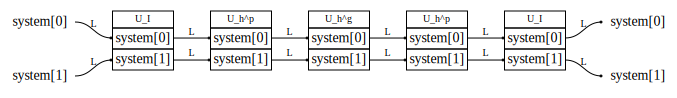

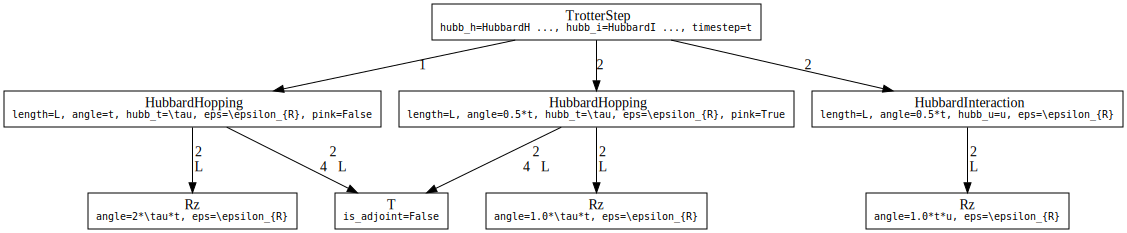

In [7]:
# TODO: Instantiate your trotter step with the appropriate sympy variables
# TODO: Visualize it to make sure it looks correct
from qualtran.drawing import show_bloq, show_call_graph

hubb_h = HubbardHopping(length, 0.5 * timestep, hubb_t, eps_r)
hubb_i = HubbardInteraction(length, 0.5 * timestep, hubb_u, eps_r) 
trotter_step = TrotterStep(hubb_h, hubb_i, timestep)
show_bloq(trotter_step.decompose_bloq())
show_call_graph(trotter_step.call_graph()[0])

Next we will replace some variables ($\epsilon_R$) and $t$. For details see the appendix of this tutorial.

In [8]:
from qualtran.resource_counting.t_counts_from_sigma import t_counts_from_sigma
from qualtran.bloqs.basic_gates import Rz
from qualtran.resource_counting.generalizers import PHI


def catch_rotations(bloq) -> Bloq:
    """Generalizer to catch rotations."""
    if isinstance(bloq, Rz):
        return Rz(angle=PHI, eps=bloq.eps)
    return bloq

def t_and_rot_counts(bloq: Bloq) -> Tuple[SymbolicInt, SymbolicInt]:
    _, sigma = bloq.call_graph(generalizer=catch_rotations)
    # TODO: compute (hint: get) the number of TGates
    t_count = sigma.get(TGate(), 0)
    n_rot = 0
    # TODO: count the number of rotations
    for bloq, counts in sigma.items():
        if isinstance(bloq, Rz):
            n_rot += counts
    return t_count, n_rot

# TODO: uncomment to compute the number of T gates and the number of rotations in a Trotter step
n_t, n_rot = t_and_rot_counts(trotter_step)
# see appendicies of tutorial for details
timestep = (delta_ts / xi) ** (1/p)
eps_r = delta_ht * timestep / n_rot

Finally compute the total T count in terms of the free parameters $\Delta_{TS}$ and $\Delta_{HT}$ and compare to the quoted result above.

In [9]:
# TODO Get the total t_counts:
hubb_h = HubbardHopping(length, 0.5 * timestep, hubb_t, eps_r)
hubb_i = HubbardInteraction(length, 0.5 * timestep, hubb_u, eps_r) 
trotter_step = TrotterStep(hubb_h, hubb_i, timestep)
t_counts = t_counts_from_sigma(trotter_step.call_graph(generalizer=catch_rotations)[1])
t_counts

5*L**2*ceiling(1.149*log2(5.0*L**2/(\Delta_{HT}*(\Delta_{TS}/xi)**(1/p))) + 9.2) + 12*L**2

## 4. Add a simple phase estimation bloq

In [14]:
from qualtran.symbolics import pi, ceil

@attrs.frozen
class AdaptivePhaseEstimation(Bloq):
    r"""Bloq implementing adaptive phase estimation given a unitary $U$

    Args:
        unitary: Bloq implementing the unitary to perform phase estimation on.

    Registers:
       system: The system register of size 2 `length`.

    References:
        [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238)
    """
    unitary: TrotterStep 
    timestep: SymbolicFloat
    eps: SymbolicFloat

    @cached_property
    def signature(self) -> Signature:
        return Signature([Register('control', QBit(), 'system', QAny(self.hubb_h.length), shape=(2,))])

    def __str__(self) -> str:
        return f'A-QPE'

    @cached_property
    def num_circuit_applications(self) -> SymbolicInt:
        # TODO: write this function
        # See https://arxiv.org/abs/1902.10673 page 8 Eq 9: N_PE = 0.76 pi / (eps * t) 
        return ceil(0.76 * pi(self.eps) / (self.eps * self.timestep))

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # TODO: Return the appropraite bloq counts 
        return {(self.unitary, self.num_circuit_applications)}
    

In [15]:
phase_estimate = AdaptivePhaseEstimation(trotter_step, timestep, delta_pe)
t_counts_pe = t_counts_from_sigma(phase_estimate.call_graph(generalizer=catch_rotations)[1])
t_counts_pe

5*L**2*ceiling(0.76*pi/(\Delta_{PE}*(\Delta_{TS}/xi)**(1/p)))*ceiling(1.149*log2(5.0*L**2/(\Delta_{HT}*(\Delta_{TS}/xi)**(1/p))) + 9.2) + 12*L**2*ceiling(0.76*pi/(\Delta_{PE}*(\Delta_{TS}/xi)**(1/p)))

## 5. (Optional) Optimize the T counts

Now that we have determined a value for the t_counts in terms of the free parameters we can try to optimize the T counts subject to the constraint that $\Delta_{TS} + \Delta_{HT} < \epsilon$

In [16]:
# TODO: Write a function to optimize the T-counts as a function of delta_ht and delta_ts subject to the constraint (assume delta_pe = 0). It is helpful to visualize the function first 
# From Ref table 1.
# Target error from Reference
L = 8
epsilon = 0.0051 * L**2
prod_ord = 2
hubb_u = 4
xi_bound = 5.3e2 
def eval_t_counts(delta_ht_val: float, delta_ts_val: float, delta_pe_val: float) -> float:
    """Evaluate the """
    return t_counts_pe.evalf(subs={length: L, delta_ts: delta_ts_val, delta_ht: delta_ht_val, xi: xi_bound, p: prod_ord, delta_pe: delta_pe_val})

You can visualize the cost function along lines of constant $\epsilon$ as follows.

Text(0.5, 0, '$\\Delta_{TS}/\\epsilon$')

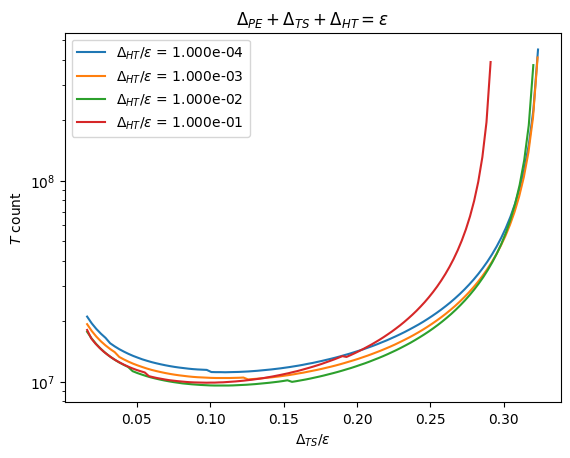

In [17]:
import numpy as np
import matplotlib.pyplot as plt

delta_ht_vals = np.array([1e-4, 1e-3, 1e-2, 1e-1]) * epsilon
fig, ax = plt.subplots()
for dht in delta_ht_vals:
    delta_ts_vals = np.linspace(0.05*epsilon , epsilon - dht, 100)[:-1]
    t_vals = []
    for dts in delta_ts_vals:
        t_vals.append(eval_t_counts(dht, dts, epsilon - dts - dht))
    ax.plot(delta_ts_vals, t_vals, label=fr'$\Delta_{{HT}} / \epsilon$ = {dht/epsilon:4.3e}')
plt.yscale('log')
plt.ylabel('$T$ count')
plt.legend()
plt.title(r'$\Delta_{PE} + \Delta_{TS} + \Delta_{HT} = \epsilon$')
plt.xlabel(r'$\Delta_{TS}/\epsilon$')

See [the qualtran example](https://github.com/quantumlib/Qualtran/blob/main/qualtran/bloqs/chemistry/trotter/hubbard/qpe_cost_optimization.ipynb) for a simple numerical optimization procedure. 

# Conclusions

It's relatively simple to build up high level algorithms in qualtran and arive at non-trivial expressions for costs in terms of free parameters of the problem. Further optimizations include merging neighbouring unitaries when repeatedly applying the Trotter circuit, and using Hamming weight phasing. 

# Appendices

###  Appendix 1. Trotter Errors

Given a $p$-th order product formula $S_p(t)$ for the unitary implementing $e^{-i t H}$ we have that
$$
\Delta_U \equiv \lVert S_p(t) - e^{-i t H}\rVert_{W_\eta} = \xi(\eta, u, \tau) t^{p+1}
$$
for some constant $\xi$ which depends on the parameters of the system. The constant $\xi$ can be either computed (through direct evaluation and extrapolating from small system sizes) or bounded using complicated commutator expressions.

Ref. [[1]](https://arxiv.org/abs/1902.10673) showed that

$$
\Delta_{TS} t \equiv |E - E_{TS}|t \le \arctan\left(\Delta_U \frac{\sqrt{4-\Delta_U^2}}{2-\Delta_U^2}\right) = \Delta_U + \frac{\Delta_U^3}{24} + \mathcal{O}(\Delta_U^5),
$$
so that as long as $\Delta_U \gg \frac{\Delta_U^3}{24}$ we can estimate

$$
\Delta_{TS} = \Delta_U / t \approx \xi(\eta, u, \tau) t^{p}
$$

### 2. Circuit Synthesis Errors

Circuit synthesis errors account for the approximate implementation of single qubit $R_z(\theta)$ rotations when compiled to  Clifford+$T$ gates. A single qubit rotation gate can be synthesized to $\epsilon_R$ error using
$$
T_\mathrm{synth} \approx 1.15 \log_2(1/\epsilon_R) + 9.2
$$
$T$ gates. Assuming ([see Appendix D corollary 1](https://arxiv.org/pdf/1605.03590)) these errors add at most linearly to the estimated phase then the cost is

$$
N_{HT} = 1.15 \log_2 \left(\frac{N_R}{\Delta_{HT} t}\right) + 9.2
$$
$T$ gates per single qubit rotation, where $N_R$ is the number of rotations per Trotter step.

### 3. QPE Errors

Phase estimation errors $\Delta_{PE}$ arise due to not computing enough bits of the phase. Adaptive phase estimation allows one to reach a RMS error of $\Delta_{PE} t$ using

$$
N_{PE} \approx \frac{0.76 \pi}{\Delta_{PE} t}
$$
repetitions of the simulation circuit.

We will ignore this cost in this tutorial.